In [1]:
from system import *
from agents import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import numpy as np
import pandas as pd
import random
import math
from tqdm import tqdm

/home/aaruran/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


No GPU will be used


In [2]:
notext_agent = ModelBased_NoText_Agent()
# e = TradingWithRedditEnv()
notext_agent.name

'Model-based without Text'

# Generating Experimental Data

In [3]:
total_history = pd.DataFrame()
with open("filtered_tickers.txt", "r") as src:
    filtered_tickers = src.read().split("\n")

agents = [DQN, A2C, DDPG, ModelBased_NoText_Agent, ModelBasedAgent]
# agents = [DQN, A2C, DDPG, ModelBasedAgent]
for A in agents:
    for ticker in tqdm(filtered_tickers[0:6]):
        a = A()
        e_train = a.ENV_CONSTRUCTOR(ticker=ticker, mode='train')
        e_test = a.ENV_CONSTRUCTOR(ticker=ticker, mode='test')
        for i in range(7):
            h_train = a.run_episode(e_train)
            h_train['mode'] = 'train'
            h_train['t'] = range(len(h_train))
            h_train['episode'] = int(i + 1)
            h_train['agent'] = a.name
            total_history = pd.concat([total_history, h_train])

        h_test = a.run_episode(e_test)
        h_test['mode'] = 'test'
        h_test['t'] = range(len(h_train), len(h_test) + len(h_train))
        h_test['agent'] = a.name
        total_history = pd.concat([total_history, h_test])
        
    

100%|██████████| 6/6 [02:38<00:00, 26.39s/it]


In [4]:
total_history

,date,ticker,rewards,actions,returns,prices,mode,t,episode,agent
Date,,,,,,,,,,
2014-01-06,2014-01-06,A,-10.050192,1.0,-0.004919,40.515022,train,0,1.0,Deep Q-Network
2014-01-07,2014-01-07,A,-9.951803,0.0,-0.002465,41.094421,train,1,1.0,Deep Q-Network
2014-01-08,2014-01-08,A,0.000000,0.0,-0.002465,41.766811,train,2,1.0,Deep Q-Network
2014-01-09,2014-01-09,A,-9.955211,-1.0,-0.001759,41.781116,train,3,1.0,Deep Q-Network
2014-01-10,2014-01-10,A,-19.808232,1.0,0.000722,42.153076,train,4,1.0,Deep Q-Network
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,2018-12-24,ABC,0.197557,-1.0,0.185319,70.760002,test,1251,NaN,Model-based
2018-12-26,2018-12-26,ABC,-0.381935,-1.0,0.147130,73.040001,test,1252,NaN,Model-based
2018-12-27,2018-12-27,ABC,-0.076958,-1.0,0.139435,73.529999,test,1253,NaN,Model-based


In [5]:
total_history['episode'].unique(), total_history['ticker'].unique(), total_history['agent'].unique()

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7., nan]),
 array(['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC'], dtype=object),
 array(['Deep Q-Network', 'A2C', 'DDPG', 'Model-based without Text',
        'Model-based'], dtype=object))

In [6]:
training_history = total_history[(total_history['mode'] == 'train')]
training_history['discounted_reward'] = (training_history.t
                                             .apply( lambda x : np.power(a.gamma, x))
                                            * training_history.rewards)
rewards_df = (
    training_history.groupby(['agent', 'ticker', 'episode'])
        .agg({'discounted_reward' : 'sum'})
        .groupby(['agent', 'episode'])
        .agg({'discounted_reward' : 'mean'})
#          .plot()
)
rewards_df
# total_history[(total_history.ticker == 'A') & (total_history['mode'] == 'train')]
# h = total_history
# h[h.mode == 'train']

discounted_reward
agent                    episode                   
A2C                      1.0             -42.812904
                         2.0             -39.229209
                         3.0             -35.733391
                         4.0             -14.814083
                         5.0              -2.903061
                         6.0              -4.078233
                         7.0              -1.670128
DDPG                     1.0              -1.478836
                         2.0              -6.269593
                         3.0              -7.530583
                         4.0              -8.599456
                         5.0              -9.454016
                         6.0             -10.216343
                         7.0              -7.813605
Deep Q-Network           1.0             -43.365160
                         2.0             -18.316240
                         3.0             -22.532536
                         4.0             -10.406980
                         5.0             -18.513964
                         6.0              -9.957473
                         7.0             -10.361722
Model-based              1.0             -36.693824
                         2.0              -7.352626
                         3.0              -7.022851
                         4.0              -7.189875
                         5.0              -7.316654
                         6.0              -6.701248
                         7.0              -6.701282
Model-based without Text 1.0             -47.640267
                         2.0              -8.391086
                         3.0              -8.179630
                         4.0              -8.179672
                         5.0              -8.268509
                         6.0             -11.586456
                         7.0              -8.179630

In [7]:
# rewards_df.reset_index(['agent', 'episode'], drop=False)

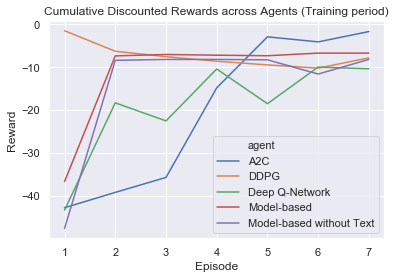

In [8]:
sns.lineplot('episode', 'discounted_reward', hue='agent',
             data=rewards_df.reset_index(['agent', 'episode'], drop=False))
plt.title('Cumulative Discounted Rewards across Agents (Training period)')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.show()

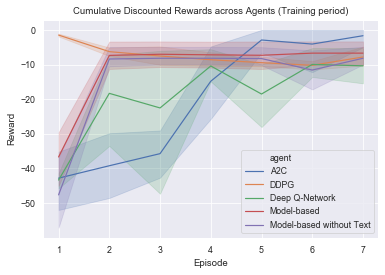

In [9]:
sns.set('paper')
sns.lineplot('episode', 'discounted_reward', hue='agent',
             data=training_history.groupby(['agent', 'ticker', 'episode'])
        .agg({'discounted_reward' : 'sum'}).reset_index(['agent', 'episode'], drop=False))
plt.title('Cumulative Discounted Rewards across Agents (Training period)')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.savefig('plots/rewards-all-agents.png')
plt.show()

In [25]:
test_history = total_history[(total_history['mode'] == 'test')]
test_history = test_history.drop(['episode', 'mode'], axis=1)

In [35]:
# test_history.actions.plot(kind='box')
test_history

,date,ticker,rewards,actions,returns,prices,t,agent
Date,,,,,,,,
2018-01-02,2018-01-02,A,-10.095072,-1.0,-0.009406,67.599998,1005,Deep Q-Network
2018-01-03,2018-01-03,A,-0.252045,-1.0,-0.034608,69.320000,1006,Deep Q-Network
2018-01-04,2018-01-04,A,0.072418,-1.0,-0.027367,68.800003,1007,Deep Q-Network
2018-01-05,2018-01-05,A,-0.155508,-1.0,-0.042916,69.900002,1008,Deep Q-Network
2018-01-08,2018-01-08,A,-0.020538,-1.0,-0.044970,70.050003,1009,Deep Q-Network
...,...,...,...,...,...,...,...,...
2018-12-24,2018-12-24,ABC,0.197557,-1.0,0.185319,70.760002,1251,Model-based
2018-12-26,2018-12-26,ABC,-0.381935,-1.0,0.147130,73.040001,1252,Model-based
2018-12-27,2018-12-27,ABC,-0.076958,-1.0,0.139435,73.529999,1253,Model-based


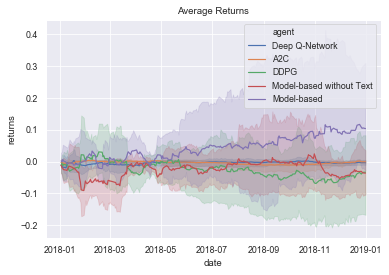

In [39]:
sns.lineplot('date', 'returns', data=test_history, hue='agent', legend='brief')
plt.title('Average Returns')
plt.savefig('plots/average-returns-all.png')

In [23]:
test_history[[(test_history.columns != 'episode') & (test_history.columns != 'mode')]]

ValueError: Item wrong length 1 instead of 7530.

,date,ticker,rewards,actions,returns,prices,t,agent
Date,,,,,,,,
2018-01-02,2018-01-02,A,-10.095072,-1.0,-0.009406,67.599998,1005,Deep Q-Network
2018-01-03,2018-01-03,A,-0.252045,-1.0,-0.034608,69.320000,1006,Deep Q-Network
2018-01-04,2018-01-04,A,0.072418,-1.0,-0.027367,68.800003,1007,Deep Q-Network
2018-01-05,2018-01-05,A,-0.155508,-1.0,-0.042916,69.900002,1008,Deep Q-Network
2018-01-08,2018-01-08,A,-0.020538,-1.0,-0.044970,70.050003,1009,Deep Q-Network
...,...,...,...,...,...,...,...,...
2018-12-24,2018-12-24,ABC,0.197557,-1.0,0.185319,70.760002,1251,Model-based
2018-12-26,2018-12-26,ABC,-0.381935,-1.0,0.147130,73.040001,1252,Model-based
2018-12-27,2018-12-27,ABC,-0.076958,-1.0,0.139435,73.529999,1253,Model-based


In [18]:
test_history.columns

Index(['date', 'ticker', 'rewards', 'actions', 'returns', 'prices', 'mode',
       't', 'episode', 'agent'],
      dtype='object')

In [ ]:
q = sns.FacetGrid(data=h[h.episode % 5 == 0], row='ticker', hue='episode', aspect=6, legend_out=True)
q.map(sns.lineplot, 'date', 'returns')

In [ ]:
a2c_agent = A2C()
a2c_agent.train(num_tickers=1, episodes_per_ticker=20)

In [ ]:
h = a2c_agent.history
df = h
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']
df.groupby(['ticker', 'episode']).agg({'discounted_reward' : 'sum'}).groupby('episode').agg({'discounted_reward' : 'mean'}).plot()

In [ ]:
h = a2c_agent.history
q = sns.FacetGrid(data=h[h.episode % 5 == 0], row='episode', aspect=6, legend_out=True)
q.map(sns.lineplot, 'date', 'returns')

In [ ]:
ddpg_agent = DDPG()
ddpg_agent.train(num_tickers=1, episodes_per_ticker=3)

In [ ]:
h = ddpg_agent.history
df = h
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']
df.groupby(['ticker', 'episode']).agg({'discounted_reward' : 'sum'}).groupby('episode').agg({'discounted_reward' : 'mean'}).plot()

In [ ]:
h = ddpg_agent.history
q = sns.FacetGrid(data=h, row='episode', aspect=6)
q.map(sns.lineplot, 'date', 'returns')

In [ ]:
long_agent = LongOnlyAgent()
long_agent.train(num_tickers=1, episodes_per_ticker=3)

In [ ]:
h = long_agent.history
df = h
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']
(df.groupby(['ticker', 'episode'])
     .agg({'discounted_reward' : 'sum'})
     .groupby('episode')
     .agg({'discounted_reward' : 'mean'})
     .plot())

In [ ]:
h = long_agent.history
q = sns.FacetGrid(data=h, row='episode', aspect=6)
q.map(sns.lineplot, 'date', 'returns')

In [ ]:
total_history = pd.DataFrame()
with open("filtered_tickers.txt", "r") as src:
    filtered_tickers = src.read().split("\n")


In [ ]:
for t in filtered_tickers:
    e_train = ModelBasedAgent.ENV_CONSTRUCTOR(t, mode='train')
    e_test  = ModelBasedAgent.ENV_CONSTRUCTOR(t, mode='test')
model_agent = ModelBasedAgent()
model_agent.train(num_tickers=1, episodes_per_ticker=)

In [ ]:
model_agent.history.head()

In [ ]:
df = model_agent.history
df['discounted_reward'] = df['t'].apply(lambda x : np.power(dqn_agent.gamma, x)) * df['rewards']

(df.groupby(['ticker', 'episode'])
     .agg({'discounted_reward' : 'sum'})
     .groupby('episode')
     .agg({'discounted_reward' : 'mean'})
     .plot(title=model_agent.name))

In [ ]:
h = model_agent.history
q = sns.FacetGrid(data=h, col='episode', row='ticker')
q.map(sns.lineplot, 't', 'returns')

In [ ]:
q = sns.FacetGrid(data=h, col='episode', row='ticker')
q.map(sns.lineplot, 't', 'rewards')

In [ ]:
sns.lineplot('t', 'prices', hue='ticker', data=h)